In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import sys
import pylab as pl
import re
import urllib.request as request
from datetime import datetime
from bs4 import BeautifulSoup
import seaborn as sns

pl.rcParams['figure.titlesize'] = 'large'
pl.rcParams['figure.figsize'] = (20, 20)
pl.rcParams['lines.linewidth'] = 7
             
% pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Collect data January & February turnstile data (2017 & 2016)

In [2]:
MTA_TURNSTILE_URL = "http://web.mta.info/developers/turnstile.html"
MTA_FILE_ROOT_URL = "http://web.mta.info/developers/"

In [3]:
'''
slightly modified from https://github.com/piratefsh/mta-turnstile-scraper/blob/master/mta_scraper.py'''

def get_site():
    f = request.urlopen(MTA_TURNSTILE_URL)
    content = f.read()
    return content

def get_turnstile_links(html):
    soup = BeautifulSoup(html, 'html.parser')
    links = soup.find_all('a')
    turnstile_links = [(link.text, MTA_FILE_ROOT_URL + link['href']) for link in links if re.match('.*day.*20..', link.text)]
    return turnstile_links 

def get_links_by_date(start, end):
    links = get_links()
    in_range = []
    for text,link in links:
        date = datetime.datetime.strptime(text , "%A, %B %d, %Y") 
        if date >= start and date <= end:
            in_range.append((text, link))
    
    return in_range

def get_links():
    return get_turnstile_links(get_site())

In [4]:
metadata = 'http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description_pre-10-18-2014.txt'
f = request.urlopen(metadata)
content = f.readlines()
col_names_14 = str(content[2]).split(',')

def turnstile_df(links, post2014 = True): 
    '''takes links and returns dataframe with all data in one
    pre 2014 was captured differently and thus requires a second argument for correct columns'''
    df = pd.DataFrame()
    if post2014 == True: 
        for text, link in links: 
            temp_df = pd.read_csv(link, parse_dates = True, infer_datetime_format = True)
            df = df.append(temp_df, ignore_index = True)
    elif post2014 == False: 
        for text, link in links: 
            temp_df = pd.read_csv(link, header = None, names = col_names_14, parse_dates = True,
                                 infer_datetime_format = True)
            df = df.append(temp_df, ignore_index = True)
    return df

In [5]:
a = get_site()
b = get_turnstile_links(a)
start = datetime.datetime(2015, 12, 27)
end = datetime.datetime(2016, 3, 7)
desired = get_links_by_date(start, end)
jf2016 = turnstile_df(desired)

In [6]:
a = get_site()
b = get_turnstile_links(a)
start = datetime.datetime(2016, 12, 27)
end = datetime.datetime(2017, 3, 7)
desired = get_links_by_date(start, end)
jf2017 = turnstile_df(desired)

In [7]:
a = get_site()
b = get_turnstile_links(a)
start = datetime.datetime(2014, 12, 27)
end = datetime.datetime(2015, 3, 7)
desired = get_links_by_date(start, end)
jf2015 = turnstile_df(desired)

In [ ]:
a = get_site()
b = get_turnstile_links(a)
start = datetime.datetime(2013, 12, 27)
end = datetime.datetime(2014, 2, 7)
desired = get_links_by_date(start, end)
jan2014 = turnstile_df(desired, False)

In [ ]:
a = get_site()
b = get_turnstile_links(a)
start = datetime.datetime(2012, 12, 27)
end = datetime.datetime(2013, 2, 7)
desired = get_links_by_date(start, end)
jan2013 = turnstile_df(desired, False)

In [ ]:
a = get_site()
b = get_turnstile_links(a)
start = datetime.datetime(2011, 12, 27)
end = datetime.datetime(2012, 2, 7)
desired = get_links_by_date(start, end)
jan2012 = turnstile_df(desired, False)

# Data Cleaning: Remove all data outside the range of January
# Desired Stations: Q 72, 86, 96
# Desired Stations: 456 - 68, 77, 86, 96

In [8]:
def mta_cleaning(df):
    # remove out of bounds dates and stations
    df.reset_index(inplace = True, drop = True)
    irt_stations = ['68ST-HUNTER CO', '68ST-HUNTER COL', '77 ST', '86 ST', '96 ST']
    irt_line = '6'
    bmt_stations = ['72 ST-2 AVE', '86 ST-2 AVE', '96 ST-2 AVE']
    bmt_line = 'Q'
        
    irt_df = df[((df.LINENAME.str.contains(irt_line)) & (df.STATION.isin(irt_stations)))]
    bmt_df = df[df.STATION.isin(bmt_stations)]
    
    UES_df = irt_df.append(bmt_df, ignore_index = True)
    
    UES_df.DATE = UES_df.DATE.apply(pd.to_datetime)
    
    month_mask = (UES_df.DATE.map(lambda x: x.month) == 1) | (UES_df.DATE.map(lambda x: x.month) == 2)
    UES_df = UES_df[month_mask]
    
    time_mask = UES_df.TIME.map(lambda x: x[-2:] == '00')
    
    return UES_df[time_mask]

In [11]:
UES_jf2017 = mta_cleaning(jf2017)
UES_jf2016 = mta_cleaning(jf2016)
UES_jf2015 = mta_cleaning(jf2015)

In [12]:
def marginal_entries(df):
    ''' takes dataframe, groups by line, station and date and sums (all turnstile counters in station)
    then calculates marginal entries from group entries'''
    
    grouped = df.groupby(['LINENAME', 'STATION', 'SCP', 'DATE', 'TIME'], as_index = False)['ENTRIES'].sum() 
    
    grouped['NEW_ENTRIES'] = np.zeros(len(grouped))
    
    stations = df['STATION'].unique()
    for station in stations: 
        
        indices = grouped[grouped.STATION == station].index.tolist()
        of_interest = np.array(grouped['ENTRIES'][indices])
        
        a = [0]
       
        for i, v in enumerate(of_interest):

            if i + 1 < len(of_interest):
                b = of_interest[i + 1] - v
                a.append(b)
                
        grouped['NEW_ENTRIES'][indices] = a
    
    # remove outliers likely due to faulty data (negative entries)
    
    reduced = grouped[grouped.NEW_ENTRIES < grouped.NEW_ENTRIES.quantile(.95)]['NEW_ENTRIES']
    reduced = reduced[reduced > 0]
    
    lower_thresh = 0
    upper_thresh = reduced.mean() + 3 * reduced.std()
                                                                           
    outlier_mask = grouped['NEW_ENTRIES'].map(lambda x: lower_thresh <= x <= upper_thresh)
    
    grouped = grouped[outlier_mask]
    
    grouped = grouped.groupby(['STATION', 'DATE', 'TIME'], as_index = False).sum()
    
    return grouped

In [13]:
UES_jf2017 = marginal_entries(UES_jf2017)
UES_jf2016 = marginal_entries(UES_jf2016)

C:\Users\shibbie\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
UES_jf2015 = marginal_entries(UES_jf2015)
UES_jf2015.STATION.replace('68ST-HUNTER COL', '68ST-HUNTER CO', inplace = True)

C:\Users\shibbie\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
UES_jf2017.to_csv('UES_jf2017.csv')
UES_jf2016.to_csv('UES_jf2016.csv')
UES_jf2015.to_csv('UES_jf2015.csv')

C:\Users\shibbie\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


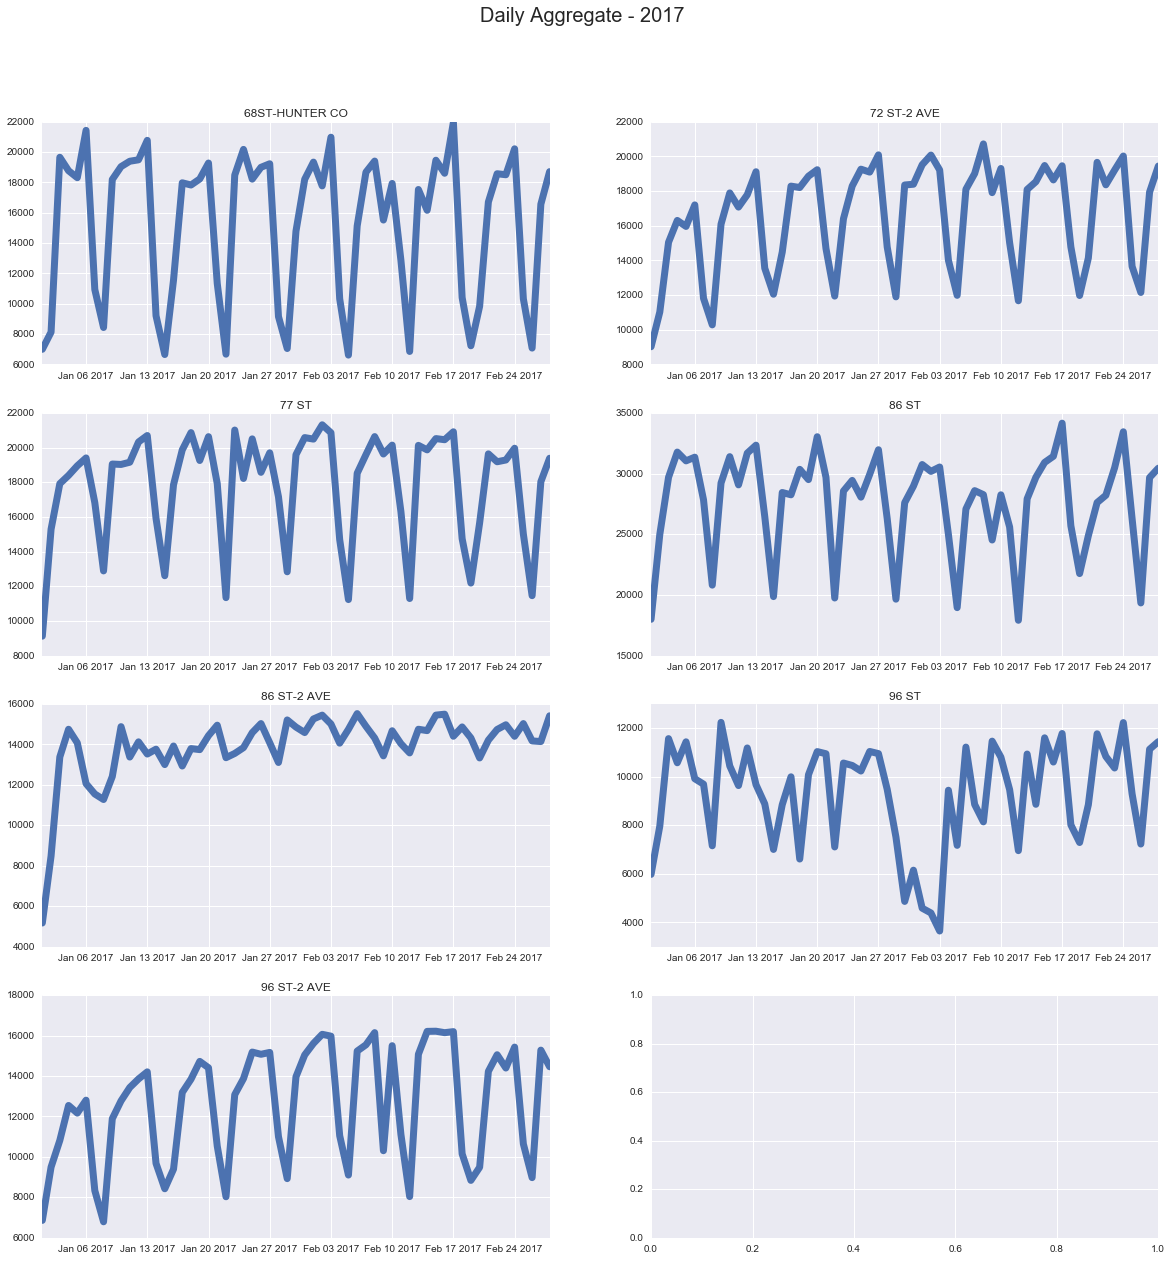

In [16]:
fig, axs = pl.subplots(4, 2, figsize = (20,20))
axs = axs.ravel()
for i, station in enumerate(UES_jf2017.STATION.unique()): 
    temp = UES_jf2017[UES_jf2017.STATION == station].groupby('DATE', as_index = False).sum()
    axs[i].plot(temp.DATE, temp.NEW_ENTRIES, '-')
    axs[i].set_title(station)
pl.legend()
pl.suptitle('Daily Aggregate - 2017', fontsize = 20)


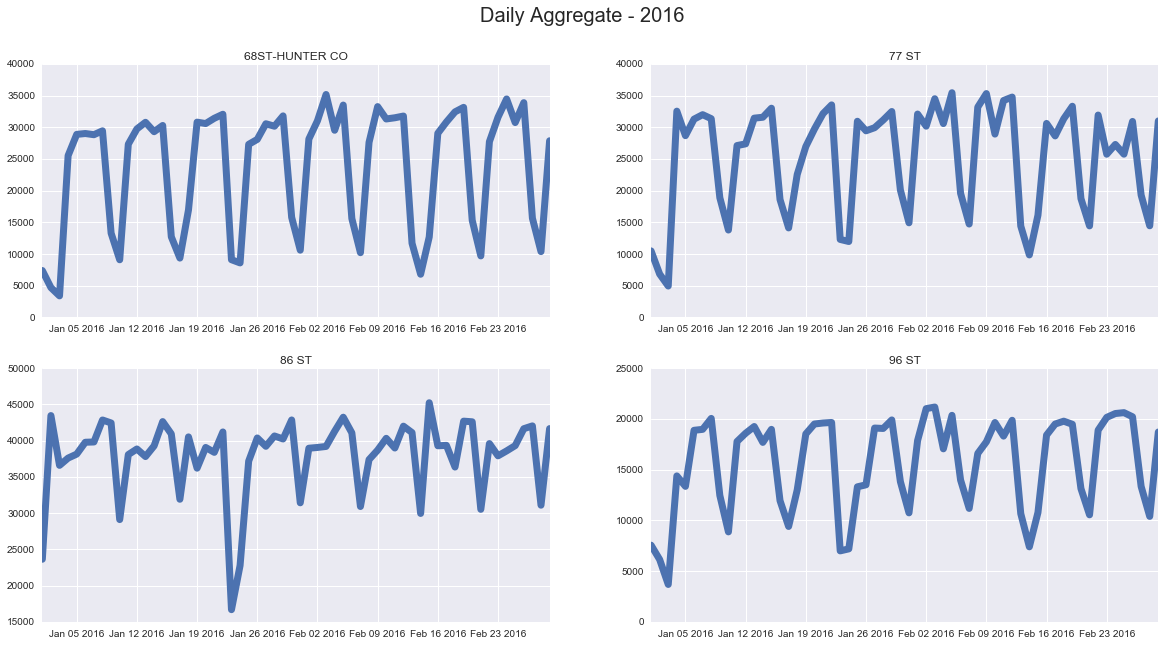

In [17]:
fig, axs = pl.subplots(2, 2, figsize = (20,10))
axs = axs.ravel()
for i, station in enumerate(UES_jf2016.STATION.unique()): 
    temp = UES_jf2016[UES_jf2016.STATION == station].groupby('DATE', as_index = False).sum()
    axs[i].plot(temp.DATE, temp.NEW_ENTRIES, '-')
    axs[i].set_title(station)
pl.suptitle('Daily Aggregate - 2016', fontsize = 20)

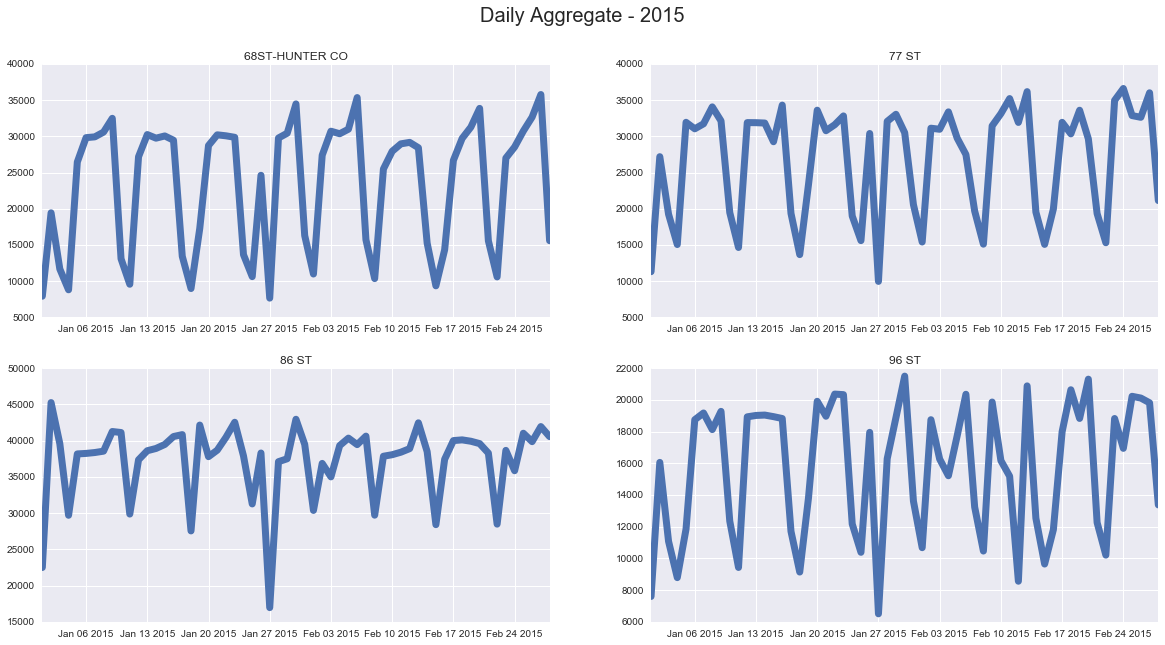

In [18]:
fig, axs = pl.subplots(2, 2, figsize = (20,10))
axs = axs.ravel()
for i, station in enumerate(UES_jf2015.STATION.unique()): 
    temp = UES_jf2015[UES_jf2015.STATION == station].groupby('DATE', as_index = False).sum()
    axs[i].plot(temp.DATE, temp.NEW_ENTRIES, '-')
    axs[i].set_title(station)
pl.suptitle('Daily Aggregate - 2015', fontsize = 20)

In [19]:
from scipy.stats import ks_2samp

In [4]:
UES_jf2015 = pd.read_csv('UES_jf2015.csv', parse_dates = True)

In [5]:
UES_jf2016 = pd.read_csv('UES_jf2016.csv', parse_dates=True)

In [6]:
UES_jf2017 = pd.read_csv('UES_jf2017.csv', parse_dates=True)

In [20]:
irt = ['68ST-HUNTER CO', '77 ST', '86 ST', '96 ST']
irt_levels = np.array([[x] * 3 for x in irt]).flatten()
dates = ['2015-2016', '2015-2017', '2016-2017'] * 4
arrays = [irt_levels, np.array(dates)]

In [21]:
pvals_ks = []
stats_ks = []
pvals_ad = []
stats_ad = []
sig_5_ad = []

In [22]:
for station in ['68ST-HUNTER CO', '77 ST', '86 ST', '96 ST']: 
    ks_2015to2016 = ks_2samp(UES_jf2015[UES_jf2015.STATION == station]['NEW_ENTRIES'], 
                    UES_jf2016[UES_jf2016.STATION == station]['NEW_ENTRIES'])
    ks_2015to2017 = ks_2samp(UES_jf2015[UES_jf2015.STATION == station]['NEW_ENTRIES'], 
                    UES_jf2017[UES_jf2017.STATION == station]['NEW_ENTRIES'])
    ks_2016to2017 = ks_2samp(UES_jf2016[UES_jf2016.STATION == station]['NEW_ENTRIES'], 
                    UES_jf2017[UES_jf2017.STATION == station]['NEW_ENTRIES'])
    

    pvalues_ks = [ks_2015to2016.pvalue, ks_2015to2017.pvalue, ks_2016to2017.pvalue]
    statistics_ks = [ks_2015to2016.statistic, ks_2015to2017.statistic, ks_2016to2017.statistic]
    
    pvals_ks.extend([round(x, 4) for x in pvalues_ks])
    stats_ks.extend([round(x, 4) for x in statistics_ks])
 

In [23]:
df = pd.DataFrame({'PValues': pvals_ks, 'Statistics': stats_ks},
                             index = arrays)

In [24]:
df

PValues  Statistics
68ST-HUNTER CO 2015-2016   0.7886      0.0484
               2015-2017   0.0000      0.2486
               2016-2017   0.0000      0.2520
77 ST          2015-2016   0.4600      0.0633
               2015-2017   0.0000      0.2966
               2016-2017   0.0000      0.2554
86 ST          2015-2016   0.8914      0.0429
               2015-2017   0.0000      0.3843
               2016-2017   0.0000      0.3718
96 ST          2015-2016   0.8717      0.0442
               2015-2017   0.0000      0.3277
               2016-2017   0.0000      0.3246

C:\Users\shibbie\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


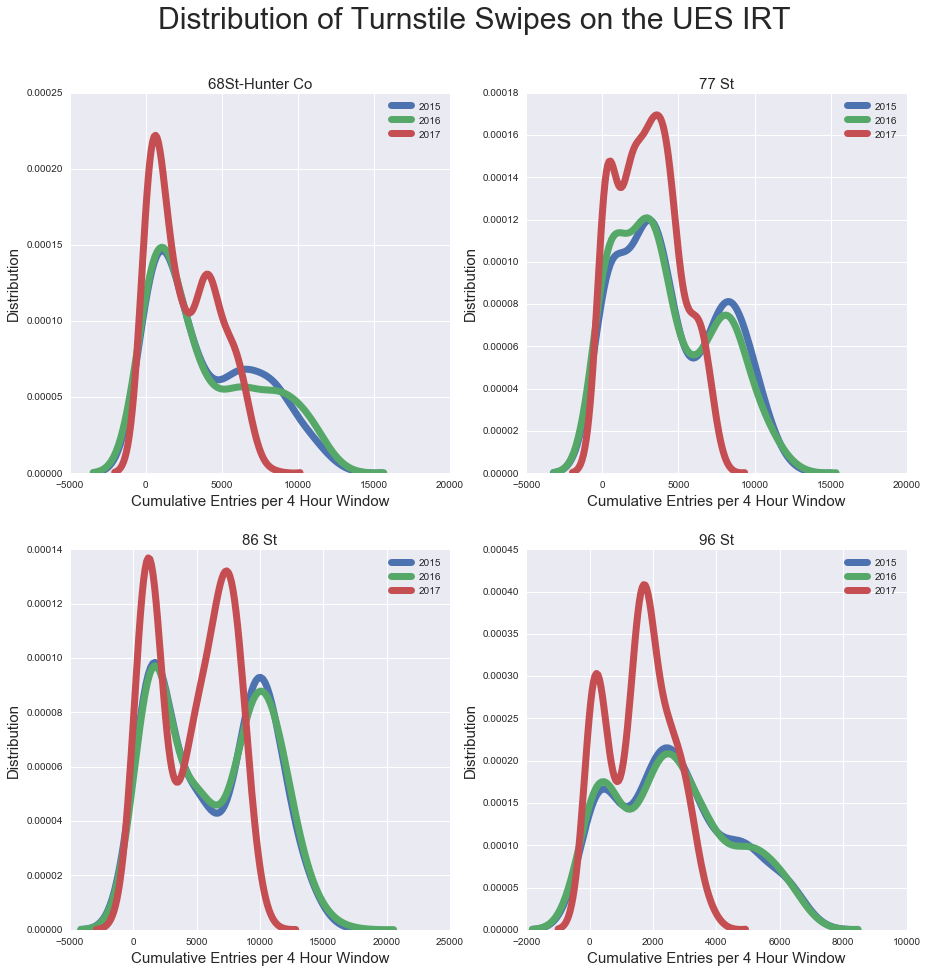

In [25]:
fig,axs = pl.subplots(2, 2, figsize = (15, 15))
axs = axs.ravel()
for i, station in enumerate(irt):

    sns.kdeplot(UES_jf2015[UES_jf2015.STATION == station]['NEW_ENTRIES'], label = '2015', ax = axs[i])
    sns.kdeplot(UES_jf2016[UES_jf2016.STATION == station]['NEW_ENTRIES'], label = '2016', ax = axs[i])
    sns.kdeplot(UES_jf2017[UES_jf2017.STATION == station]['NEW_ENTRIES'], label = '2017', ax = axs[i])
    axs[i].set_title('{0}'.format(station.title()), size = 15)
    axs[i].set_ylabel('Distribution', size = 15)
    axs[i].set_xlabel('Cumulative Entries per 4 Hour Window', size = 15)
    

pl.suptitle('Distribution of Turnstile Swipes on the UES IRT', size = 30)


C:\Users\shibbie\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


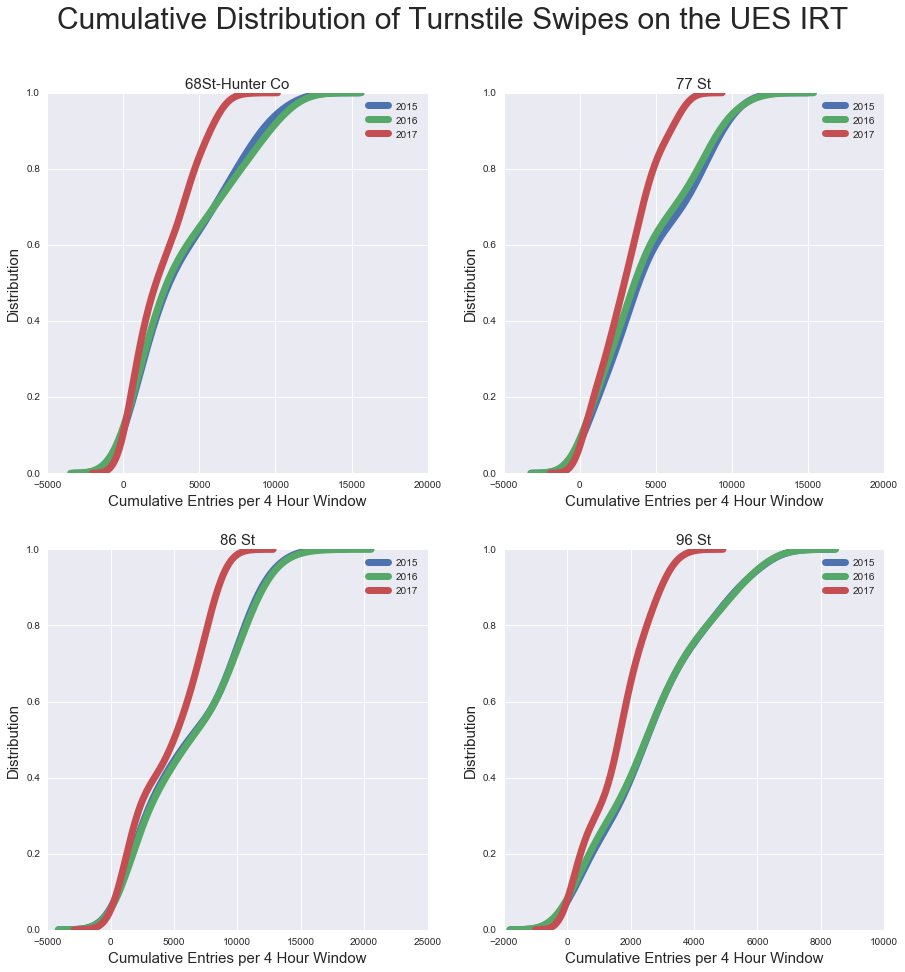

In [26]:
fig,axs = pl.subplots(2, 2, figsize = (15, 15))
axs = axs.ravel()
for i, station in enumerate(irt):

    sns.kdeplot(UES_jf2015[UES_jf2015.STATION == station]['NEW_ENTRIES'], label = '2015', ax = axs[i], cumulative = True)
    sns.kdeplot(UES_jf2016[UES_jf2016.STATION == station]['NEW_ENTRIES'], label = '2016', ax = axs[i], cumulative = True)
    sns.kdeplot(UES_jf2017[UES_jf2017.STATION == station]['NEW_ENTRIES'], label = '2017', ax = axs[i], cumulative = True)
    axs[i].set_title('{0}'.format(station.title()), size = 15)
    axs[i].set_ylabel('Distribution', size = 15)
    axs[i].set_xlabel('Cumulative Entries per 4 Hour Window', size = 15)
    

pl.suptitle('Cumulative Distribution of Turnstile Swipes on the UES IRT', size = 30)

In [27]:
UES_jf2016 = pd.read_csv('UES_jf2016.csv', parse_dates = [3], index_col = False)

In [28]:
UES_jf2017 = pd.read_csv('UES_jf2017.csv', parse_dates= [2], index_col = False)
UES_jf2015 = pd.read_csv('UES_jf2015.csv', parse_dates= [2], index_col = False)

In [29]:
UES_jf2016.DATE = pd.to_datetime(UES_jf2016.DATE)
UES_jf2015.DATE = pd.to_datetime(UES_jf2015.DATE)
UES_jf2017.DATE = pd.to_datetime(UES_jf2017.DATE)

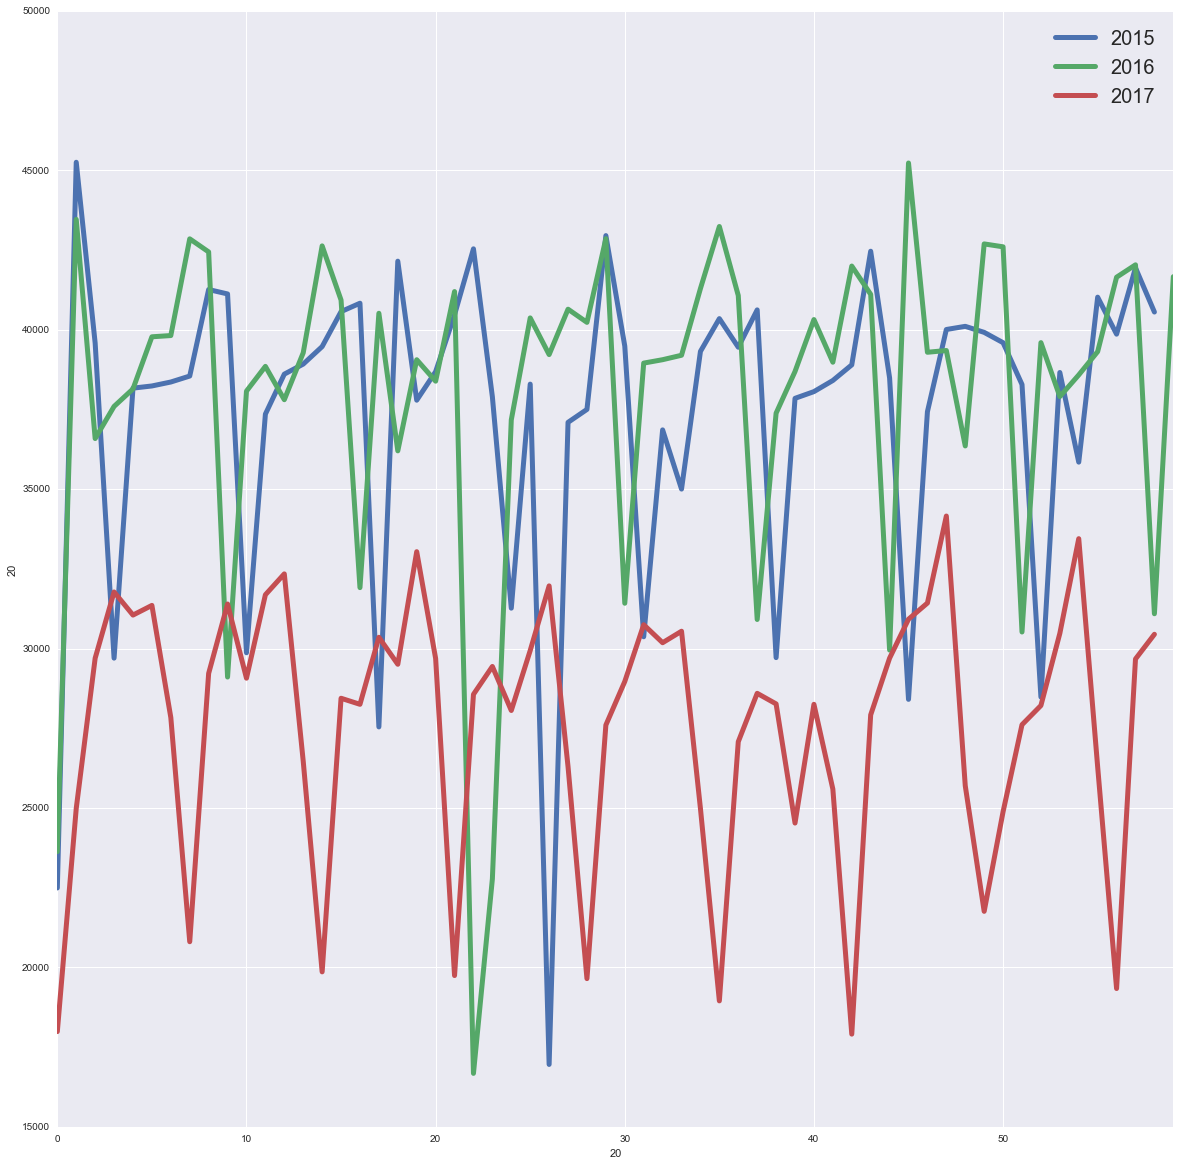

In [30]:
fig, ax = pl.subplots(figsize = (20, 20))

df_list = [UES_jf2015, UES_jf2016, UES_jf2017]

df_list2 = [x[x.STATION == '86 ST'].groupby('DATE', as_index = False).sum() for x in df_list]
for df in df_list2: 
    df.plot(np.arange(0, len(df)), 'NEW_ENTRIES', use_index = True, ax = ax, label = str(df.DATE[0].year), linewidth = 5)

pl.legend(fontsize = 20)
pl.xlabel(s = 20)
pl.ylabel(s = 20)


C:\Users\shibbie\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


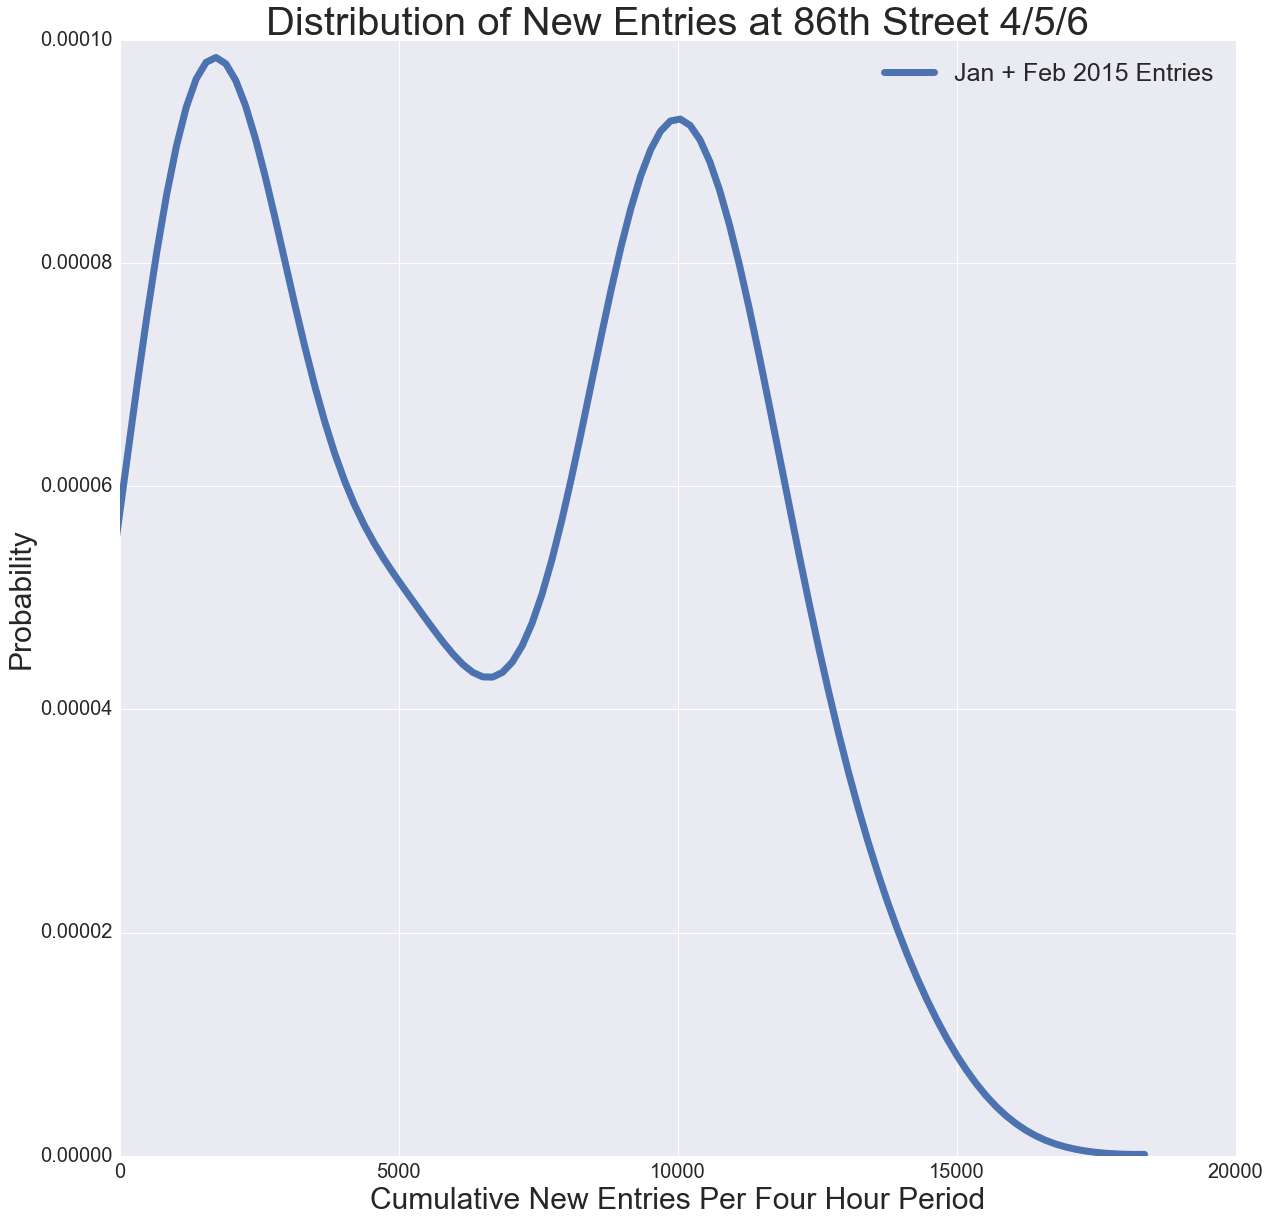

In [42]:
fig, ax = pl.subplots(figsize = (20, 20))

sns.kdeplot(UES_jf2015[UES_jf2015.STATION == '86 ST'].NEW_ENTRIES, ax = ax, label = 'Jan + Feb 2015 Entries')
pl.xlim(0, 20000)
pl.xlabel(s= 'Cumulative New Entries Per Four Hour Period', fontsize = 30)
pl.ylabel(s = 'Probability', fontsize = 30)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.title('Distribution of New Entries at 86th Street 4/5/6', fontsize = 40)
pl.legend(fontsize = 25)

C:\Users\shibbie\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


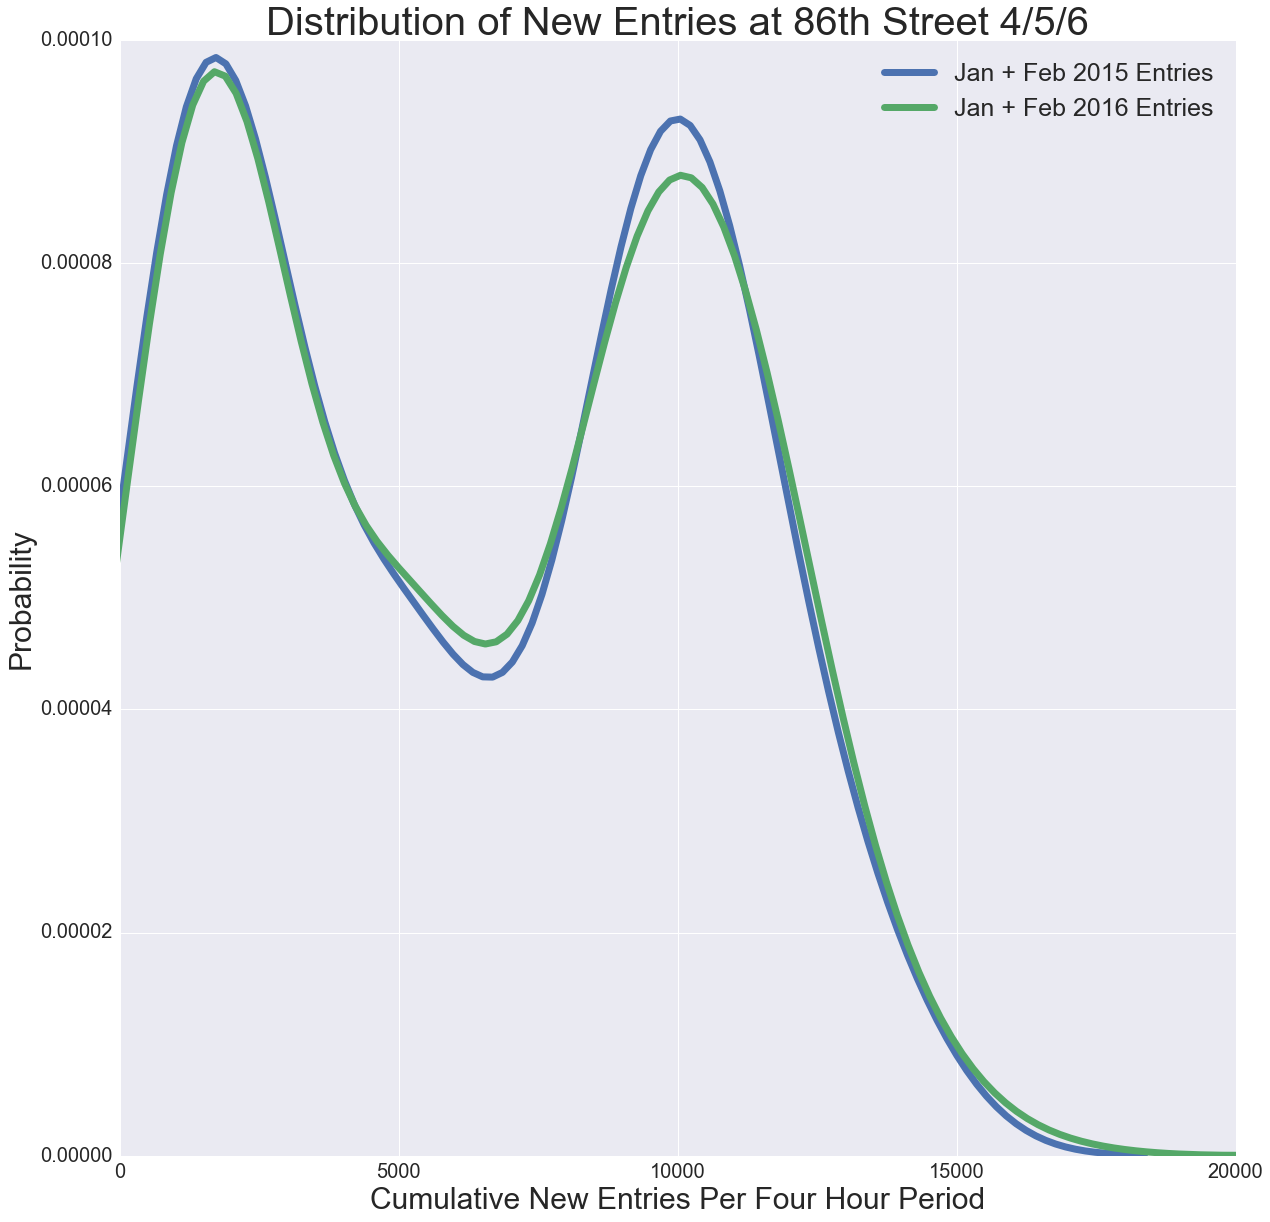

In [43]:
fig, ax = pl.subplots(figsize = (20, 20))

sns.kdeplot(UES_jf2015[UES_jf2015.STATION == '86 ST'].NEW_ENTRIES, ax = ax, label = 'Jan + Feb 2015 Entries')
pl.xlim(0, 20000)
pl.xlabel(s= 'Cumulative New Entries Per Four Hour Period', fontsize = 30)
pl.ylabel(s = 'Probability', fontsize = 30)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.title('Distribution of New Entries at 86th Street 4/5/6', fontsize = 40)
pl.legend(fontsize = 20)

sns.kdeplot(UES_jf2016[UES_jf2016.STATION == '86 ST'].NEW_ENTRIES, ax = ax, label = 'Jan + Feb 2016 Entries')
pl.xlim(0, 20000)
pl.xlabel(s= 'Cumulative New Entries Per Four Hour Period', fontsize = 30)
pl.ylabel(s = 'Probability', fontsize = 30)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.title('Distribution of New Entries at 86th Street 4/5/6', fontsize = 40)
pl.legend(fontsize = 25)

C:\Users\shibbie\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


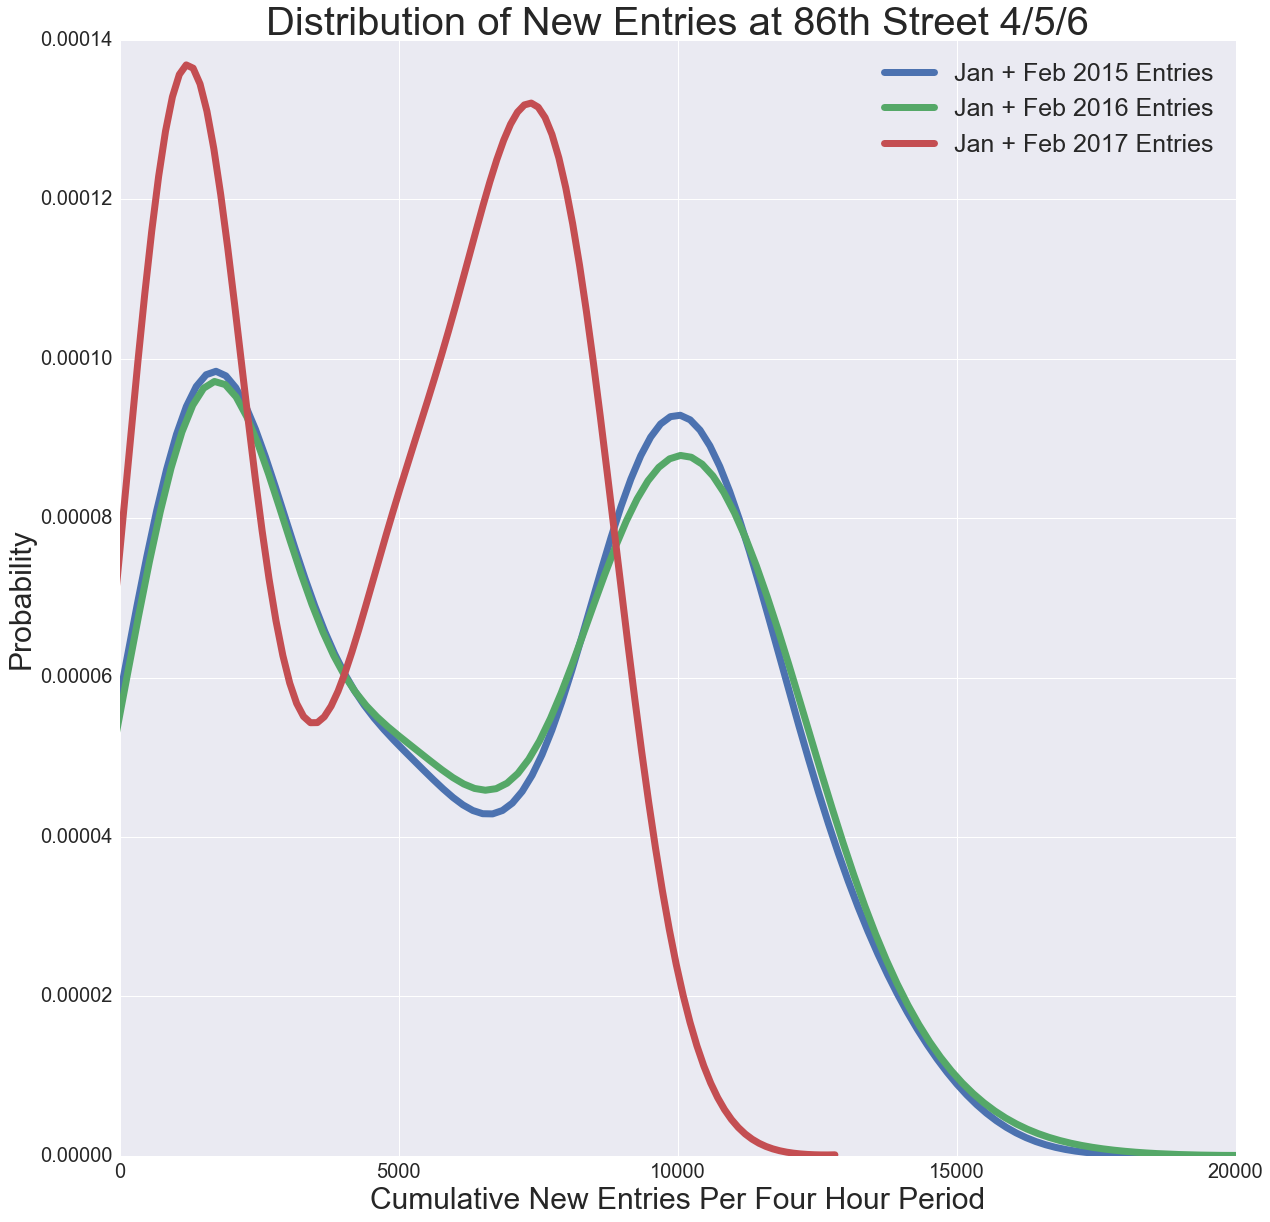

In [44]:
fig, ax = pl.subplots(figsize = (20, 20))

sns.kdeplot(UES_jf2015[UES_jf2015.STATION == '86 ST'].NEW_ENTRIES, ax = ax, label = 'Jan + Feb 2015 Entries')
pl.xlim(0, 20000)
pl.xlabel(s= 'Cumulative New Entries Per Four Hour Period', fontsize = 30)
pl.ylabel(s = 'Probability', fontsize = 30)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.title('Distribution of New Entries at 86th Street 4/5/6, 2015', fontsize = 40)
pl.legend(fontsize = 20)

sns.kdeplot(UES_jf2016[UES_jf2016.STATION == '86 ST'].NEW_ENTRIES, ax = ax, label = 'Jan + Feb 2016 Entries')
pl.xlim(0, 20000)
pl.xlabel(s= 'Cumulative New Entries Per Four Hour Period', fontsize = 30)
pl.ylabel(s = 'Probability', fontsize = 30)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.title('Distribution of New Entries at 86th Street 4/5/6, 2015', fontsize = 40)
pl.legend(fontsize = 20)

sns.kdeplot(UES_jf2017[UES_jf2017.STATION == '86 ST'].NEW_ENTRIES, ax = ax, label = 'Jan + Feb 2017 Entries')
pl.xlim(0, 20000)
pl.xlabel(s= 'Cumulative New Entries Per Four Hour Period', fontsize = 30)
pl.ylabel(s = 'Probability', fontsize = 30)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.title('Distribution of New Entries at 86th Street 4/5/6', fontsize = 40)
pl.legend(fontsize = 25)

C:\Users\shibbie\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


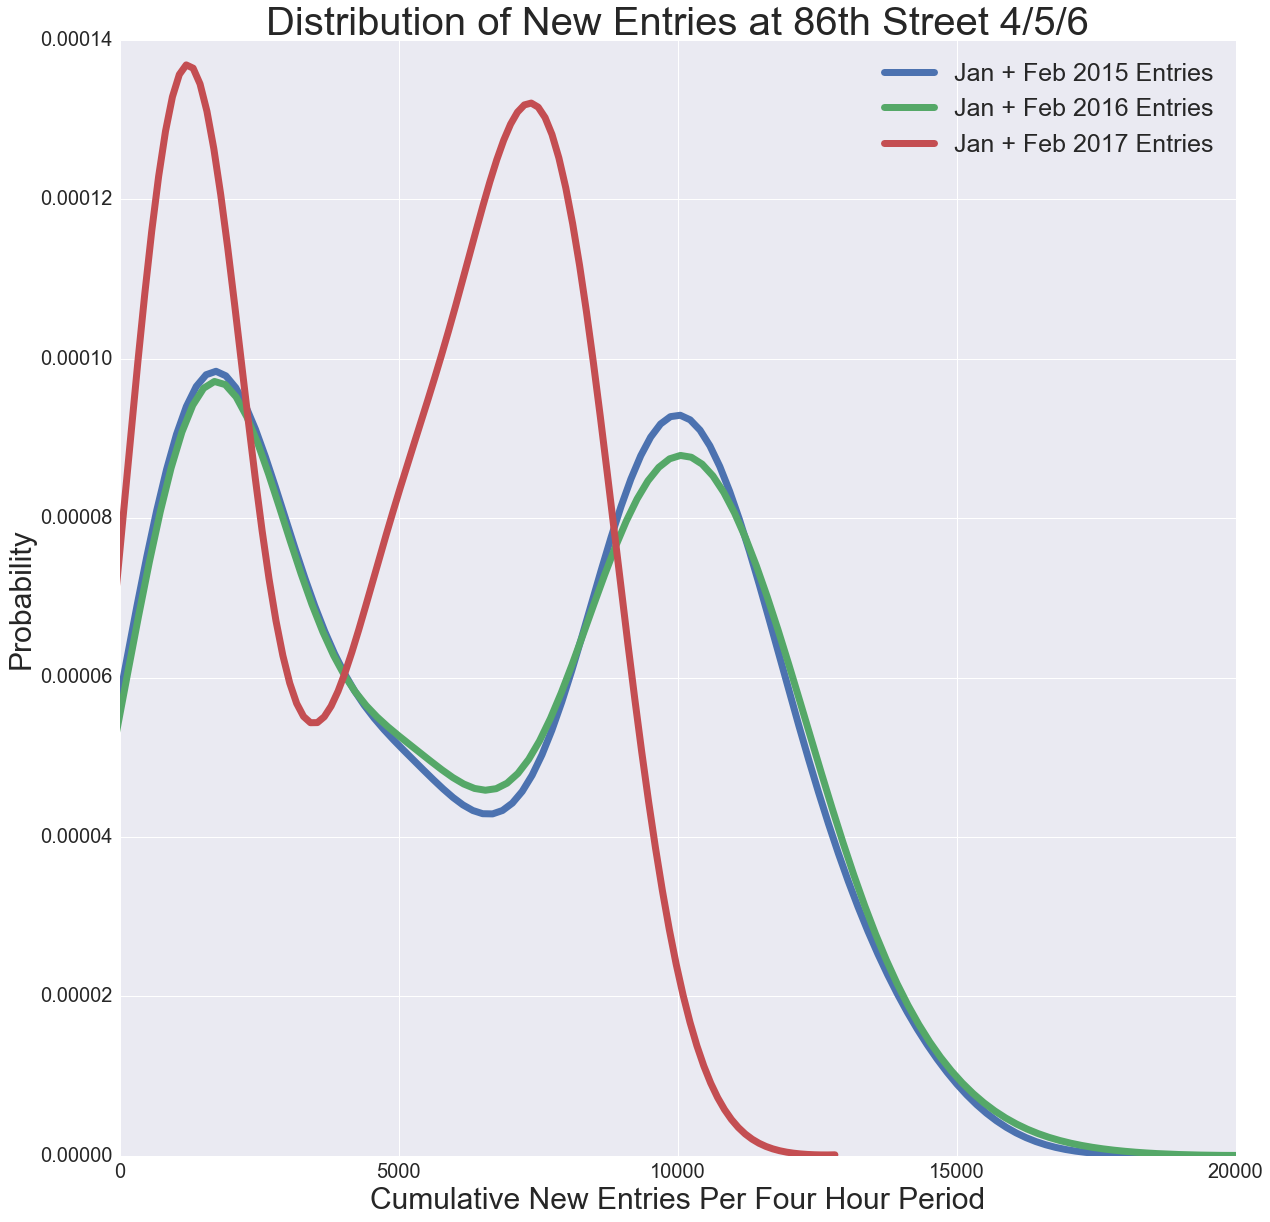

In [33]:
fig, ax = pl.subplots(figsize = (20, 20))

sns.kdeplot(UES_jf2015[UES_jf2015.STATION == '86 ST'].NEW_ENTRIES, ax = ax, label = 'Jan + Feb 2015 Entries')
pl.xlim(0, 20000)
pl.xlabel(s= 'Cumulative New Entries Per Four Hour Period', fontsize = 30)
pl.ylabel(s = 'Probability', fontsize = 30)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.title('Distribution of New Entries at 86th Street 4/5/6, 2015', fontsize = 40)
pl.legend(fontsize = 20)

sns.kdeplot(UES_jf2016[UES_jf2016.STATION == '86 ST'].NEW_ENTRIES, ax = ax, label = 'Jan + Feb 2016 Entries')
pl.xlim(0, 20000)
pl.xlabel(s= 'Cumulative New Entries Per Four Hour Period', fontsize = 30)
pl.ylabel(s = 'Probability', fontsize = 30)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.title('Distribution of New Entries at 86th Street 4/5/6, 2015', fontsize = 40)
pl.legend(fontsize = 20)

sns.kdeplot(UES_jf2017[UES_jf2017.STATION == '86 ST'].NEW_ENTRIES, ax = ax, label = 'Jan + Feb 2017 Entries')
pl.xlim(0, 20000)
pl.xlabel(s= 'Cumulative New Entries Per Four Hour Period', fontsize = 30)
pl.ylabel(s = 'Probability', fontsize = 30)
pl.xticks(fontsize = 20)
pl.yticks(fontsize = 20)
pl.title('Distribution of New Entries at 86th Street 4/5/6', fontsize = 40)
pl.legend(fontsize = 25)

In [34]:
jf2015_byday = UES_jf2015[UES_jf2015.STATION.str.contains('86')].groupby('DATE', as_index = False).sum()
jf2016_byday = UES_jf2016[UES_jf2016.STATION.str.contains('86')].groupby('DATE', as_index = False).sum()
jf2017_irtbyday = UES_jf2017[UES_jf2017.STATION == '86 ST'].groupby('DATE', as_index = False).sum()
jf2017_allbyday = UES_jf2017[UES_jf2017.STATION.str.contains('86')].groupby('DATE', as_index = False).sum()

In [35]:
jf2017_indbyday = UES_jf2017[UES_jf2017.STATION == '86 ST-2 AVE'].groupby('DATE', as_index = False).sum()

In [36]:
jf2015_byday['Weekday'] = jf2015_byday.DATE.apply(lambda x: x.weekday())
jf2016_byday['Weekday'] = jf2016_byday.DATE.apply(lambda x: x.weekday())
jf2017_irtbyday['Weekday'] = jf2017_irtbyday.DATE.apply(lambda x: x.weekday())
jf2017_allbyday['Weekday'] = jf2017_allbyday.DATE.apply(lambda x: x.weekday())

In [37]:
jf2017_indbyday['Weekday'] = jf2017_indbyday.DATE.apply(lambda x: x.weekday())

In [38]:
daysofweek = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

jf2015_byday = jf2015_byday.groupby('Weekday').mean()
jf2016_byday = jf2016_byday.groupby('Weekday').mean()
jf2017_allbyday = jf2017_allbyday.groupby('Weekday').mean()
jf2017_irtbyday = jf2017_irtbyday.groupby('Weekday').mean()

In [39]:
jf2017_indbyday = jf2017_indbyday.groupby('Weekday').mean()

(array([     0.,  10000.,  20000.,  30000.,  40000.,  50000.]),
 <a list of 6 Text yticklabel objects>)

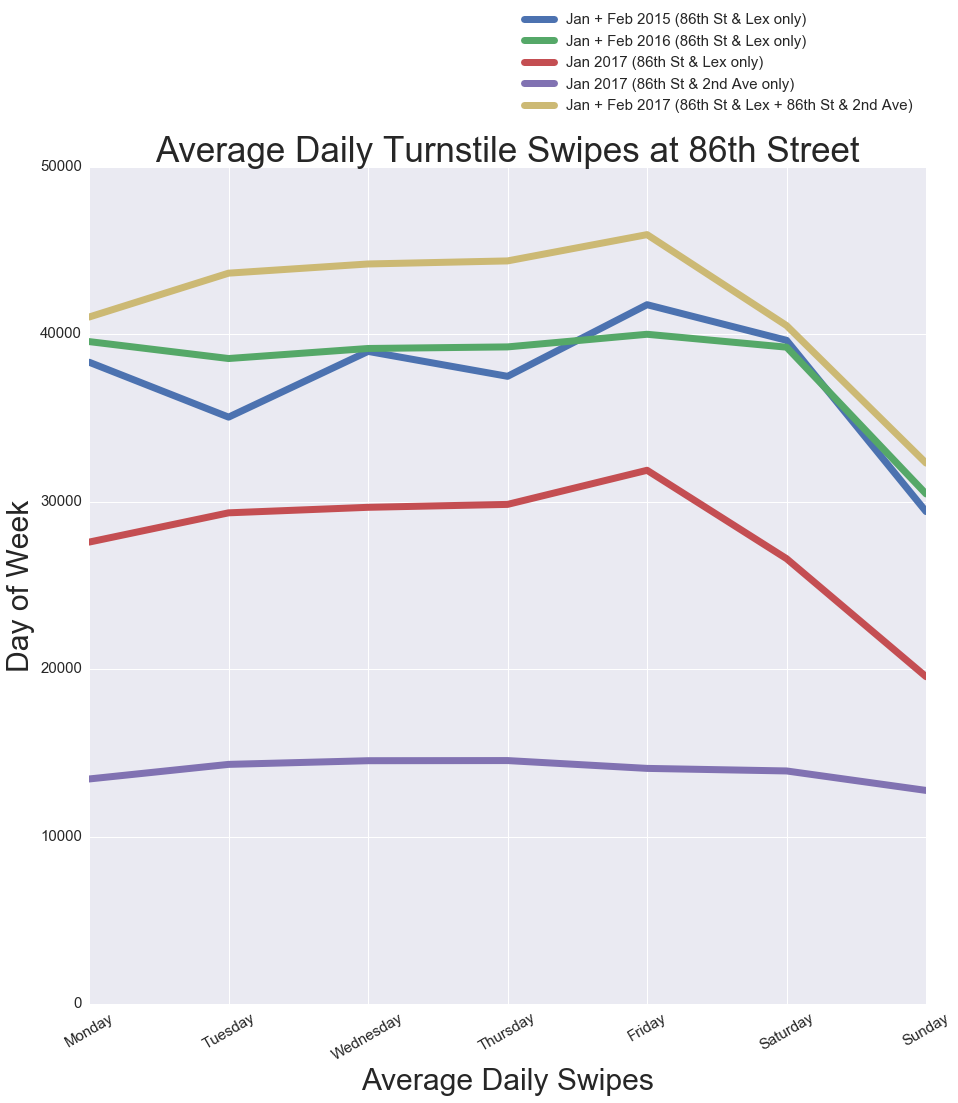

In [41]:
fig, ax = pl.subplots(figsize = (15, 15))

pl.plot(jf2015_byday.NEW_ENTRIES, label = 'Jan + Feb 2015 (86th St & Lex only)')
pl.plot(jf2016_byday.NEW_ENTRIES, label = 'Jan + Feb 2016 (86th St & Lex only)')
pl.plot(jf2017_irtbyday.NEW_ENTRIES, label = 'Jan 2017 (86th St & Lex only)')
pl.plot(jf2017_indbyday.NEW_ENTRIES, label = 'Jan 2017 (86th St & 2nd Ave only)')
pl.plot(jf2017_allbyday.NEW_ENTRIES, label = 'Jan + Feb 2017 (86th St & Lex + 86th St & 2nd Ave)')

pl.title('Average Daily Turnstile Swipes at 86th Street', fontsize = 35)
pl.xlabel('Average Daily Swipes', fontsize = 30)
pl.ylabel('Day of Week', fontsize = 30)
ax.set_xticklabels(daysofweek, rotation = 30, fontsize = 20)
pl.ylim([0, 50000])

pl.legend(fontsize = 15, bbox_to_anchor = (1, 1.2))
pl.xticks(fontsize = 15)
pl.yticks(fontsize = 15)

In [65]:
jf2017_allbyday = UES_jf2017[UES_jf2017.STATION.str.contains('86')].groupby('DATE', 
                                    as_index = False).sum().groupby('Weekday').mean()